In [36]:
import os,time,math,signal,random,shutil
import matplotlib.pyplot as plt
# Use Tensorflow V1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import input_data
from decimal import Decimal

In [37]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

In [38]:
class FitNN:
    def __init__(self, train_inputs, train_stouts, layers):
        self.layers = layers
        self.num_layers = len(self.layers)
        # Training Data
        self.inputs = train_inputs
        self.stouts = train_stouts
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(self.layers)
        # tf placeholders and graph
        self.sess = tf.Session()
        self.saver = tf.train.Saver() # To Save Trainning Process
        self.MODEL_SAVE_PATH = './model/'
        self.MODEL_NAME='fitNN_model'
        self.LOG_NAME = './log'
        self.merged = tf.summary.merge_all()
        self.writer = tf.summary.FileWriter(self.LOG_NAME, self.sess.graph)
        self.input_tf = tf.placeholder(tf.float32, shape=[None, self.layers[0]])
        self.stout_tf =  tf.placeholder(tf.float32, shape=[None, self.layers[-1]])
        self.out_pred = self.neural_net(self.input_tf, self.weights, self.biases) 

        self.loss = tf.reduce_mean(tf.square(self.log10(self.stout_tf) - self.out_pred))
        self.optimizer = tf.train.AdamOptimizer(0.00001)
        self.train_op = self.optimizer.minimize(self.loss)
        self.batch_size = 100

        self.wb_rec_path = './wb_rec/'
        if os.path.exists(self.wb_rec_path) != True:
            os.makedirs(self.wb_rec_path)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)   


    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for i in range(0,num_layers-1):
            W = tf.Variable(tf.random_normal([layers[i],layers[i+1]]))
            b = tf.Variable(tf.zeros([1,layers[i+1]]) + 0.1)
            weights.append(W)
            biases.append(b)
        return weights,biases

    def log10(self, x):
        numerator = tf.log(x)
        denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator

    def neural_net(self, inputs, weights, biases):
        num_layers = len(weights) + 1 
        h = self.log10(inputs)
        for l in range(num_layers - 2):
            W = weights[l]
            b = biases[l]
            h = tf.nn.sigmoid(tf.add(tf.matmul(h,W),b))
        W = weights[-1]
        b = biases[-1]
        h = tf.add(tf.matmul(h,W),b)
        return h
    
    def train(self,nIter):
        tf_train_dict = {
                        self.input_tf: self.inputs, self.stout_tf: self.stouts
                        }
        
        # Restore Last Training Model 
        ckpt = tf.train.get_checkpoint_state(self.MODEL_SAVE_PATH)
        if ckpt and ckpt.model_checkpoint_path:
           self.saver.restore(self.sess, ckpt.model_checkpoint_path)
           print("Model Restored.")
        
        mini_batches_i = [self.inputs[k:k+self.batch_size] for k in range(0,len(self.inputs), self.batch_size)]
        mini_batches_sto = [self.stouts[k:k+self.batch_size] for k in range(0,len(self.stouts), self.batch_size)]
        start_time = time.time()
        begin_time = start_time
        for it in range(nIter):
            # Use every batch to update weights and biases
            self.sess.run(self.train_op, tf_train_dict)
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_train_dict)
                print('It: %d, Loss: %.5e, Time: %.2f' %(it, loss_value, elapsed))
                start_time = time.time()
            # Save weights and biases every 1000 epoch
            if it % 1000 == 0:
                rec_folder_name = str(it) +'wbRec/'
                if os.path.exists(self.wb_rec_path+rec_folder_name) != True:
                    os.makedirs(self.wb_rec_path+rec_folder_name)  
                for j in range(self.num_layers-1):
                    temp_w_rec = self.weights[j].eval(session=self.sess)
                    temp_b_rec = self.biases[j].eval(session=self.sess)
                    np.save(self.wb_rec_path+rec_folder_name+'w_rec'+str(j+1)+'.npy', temp_w_rec) 
                    np.save(self.wb_rec_path+rec_folder_name+'b_rec'+str(j+1)+'.npy', temp_b_rec)   
                np.save('loss.npy',loss_value)
                text_file = open("loss.txt", "a")
                loss_for_save =str(it) + ' ' + format_e(loss_value) + ' ' + str(time.time() - begin_time) + '\n' 
                text_file.write(loss_for_save)
                text_file.close()   
                # Save model 
                self.saver.save(self.sess, os.path.join(self.MODEL_SAVE_PATH, self.MODEL_NAME))
         

In [39]:
os.system('mv loss.txt loss_last.txt')
wraper = input_data.DataWrapper()
h_layers = 5
h_nodes = 20
folder = './wb_rec/'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

layers = [2] + [h_nodes]*h_layers + [1]
text_file = open("nn_structure.txt", "w")
layers_for_save = 'hlayers:' + str(h_layers) + ' hnodes:' + str(h_nodes)
text_file.write(layers_for_save)
text_file.close()
np.save('./wb_rec/layers.npy',layers)

In [40]:
train_i,train_l = wraper.read_data_sets(wraper.all_data)
model = FitNN(train_i,train_l,layers)
# model.train(600000)
model.train(10000)

It: 0, Loss: 4.78553e+00, Time: 0.07
It: 100, Loss: 4.64700e+00, Time: 1.15
It: 200, Loss: 4.51994e+00, Time: 0.39
It: 300, Loss: 4.40319e+00, Time: 0.56
It: 400, Loss: 4.29556e+00, Time: 0.54
It: 500, Loss: 4.19605e+00, Time: 0.48
It: 600, Loss: 4.10387e+00, Time: 0.47
It: 700, Loss: 4.01834e+00, Time: 0.53
It: 800, Loss: 3.93886e+00, Time: 0.50
It: 900, Loss: 3.86488e+00, Time: 0.42
It: 1000, Loss: 3.79591e+00, Time: 0.42
It: 1100, Loss: 3.73149e+00, Time: 0.70
It: 1200, Loss: 3.67120e+00, Time: 0.44
It: 1300, Loss: 3.61464e+00, Time: 0.47
It: 1400, Loss: 3.56142e+00, Time: 0.42
It: 1500, Loss: 3.51117e+00, Time: 0.44
It: 1600, Loss: 3.46354e+00, Time: 0.39
It: 1700, Loss: 3.41819e+00, Time: 0.40
It: 1800, Loss: 3.37481e+00, Time: 0.46
It: 1900, Loss: 3.33310e+00, Time: 0.63
It: 2000, Loss: 3.29279e+00, Time: 0.38
It: 2100, Loss: 3.25361e+00, Time: 0.55
It: 2200, Loss: 3.21533e+00, Time: 0.37
It: 2300, Loss: 3.17774e+00, Time: 0.41
It: 2400, Loss: 3.14067e+00, Time: 0.40
It: 2500, Lo

In [41]:
import pandas as pd

In [42]:
df = pd.read_csv('loss.txt',sep=' ', header=None)

In [43]:
import matplotlib.pyplot as plt

In [44]:
# df.loc[:,2]

Text(0.5, 0, 'epoch')

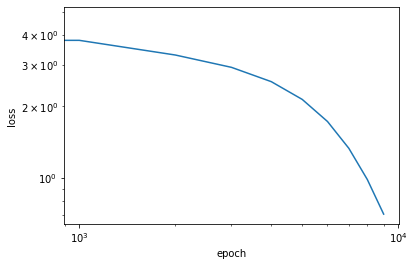

In [45]:
plt.loglog(df.loc[:,0],df.loc[:,1])
plt.ylabel('loss')
plt.xlabel('epoch')

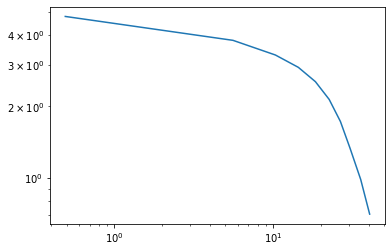

In [46]:
plt.loglog(df.loc[:,2],df.loc[:,1])